<a href="https://colab.research.google.com/github/racheleast/compare_optimizers/blob/main/Final_693.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Comparative Study of Differents Optimizers in Predicting Digits Using Neural Networks** </center>


$~~~$ **Optimizers** are algorithms  used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses.<br>

$~~~$ Optimization algorithms are responsible for reducing the losses and **to provide the most accurate results possible**.<br>

In this study we are going to build a neural network to classify digits based on mnist dataset using differents optimzers and then compare the performace of each optimizer.

In [ ]:
# First we import the necessary libraries to build and to visualize the results.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf #pip install tensorflow
from keras.utils.np_utils import to_categorical #pip install keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adadelta,Adagrad,Adam,Adamax,Ftrl,Nadam,RMSprop,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

## **Take a Look at the Data**

First we load the mnist data from keras pre-defined datasets, after that we got two subsets : 
* **Training data** : The subset that we will use to train our network.
* **Test data** : To test the final model accuracy , and to compare our optimizers.


What the data represents:

* **x_train, x_test** : Arrays of grayscale image data with shapes
* **y_train, y_test:** : Arrays of digit labels (integers in range 0-9) with shapes


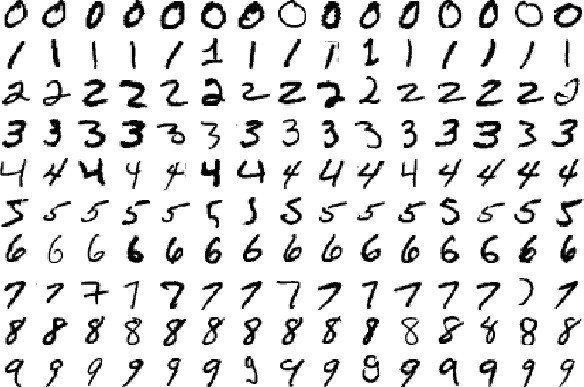

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


This is a dataset of 60,000 28x28 grayscale training images, along with a test set of 10,000 images. We are trying to classify the digits numbers (0 to 9) , so our data has 10 classes as we can see from the plot below. 




/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


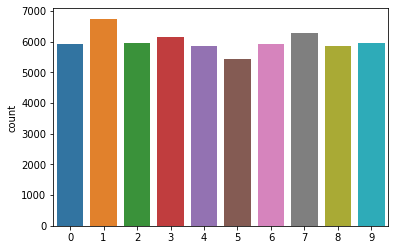

In [ ]:
g = sns.countplot(y_train)

## **Data preparation**

For a grayscale images, the pixel value is a single number that represents the brightness of the pixel. The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255. Typically zero is taken to be black, and 255 is taken to be white.

**Normalization** is a main step on data preparation.<br>
Our data is a set of grayscale images, so we perform a grayscale normalization.

Moreover the convolutional neural  network converges faster on [0..1] data than on [0..255].

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Last step is before going to build our CNN model is to **reshape** the data. Keras requires an extra dimension in the end which corresponds to channels. MNIST images are gray scaled so it uses only one channel. 

Different types of images have different numbers of channels 

* **RGB** : 3 Channels, would have reshaped vectors to 28x28x3 3D matrices.
* **Gray Scale** : 1 channel
* **Monochrome Image** : Has one number per pixel and has 1 channel

In [ ]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Label encoding**
Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vector (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [ ]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

## **The convolutional neural network (CNN)**

### **Building the model**

I am going to use the Sequential model from Keras. 

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choose to set 32 filters for the first two conv2D layers and 64 filters for the last two. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) the higher the dimension, the more the downsampling becomes important.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. This randomly drops a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

The Flatten layer is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end I used the features in two fully-connected (Dense) layers which is just an artificial neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

### **Set the optimizer**

In this part we will do the following : 
* Define the optimzer.
* Define the loss and the accuracy metric to mesure the performance of each optimzer.<br>

Once our layers are added to the model, we need to set up a loss function and an optimization algorithm.

We define the **loss function** to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications called the "categorical_crossentropy". We use this crossentropy loss function when there are two or more label classes.

The most important function is **the optimizer**. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons) **in order to minimize the loss.**

In this stage we will use the following optmizers:
* **Adadelta**
* **Adagrad**
* **Adam**
* **Adamax**
* **Ftrl**
* **Nadam**
* **RMSprop**
* **SGD**

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation). <br> <br>
**In brief here is the process :** <br>
**1- We define a loss function.**<br>
**2- We choose an optimzer that will minimze this loss.**<br>
**3- We mesure the accuracy to test the optimzer performances.**<br>

In [ ]:
# In the code here we Define the optimizer
optimizer = SGD(lr=0.001, decay=0.0)

In [ ]:
# Then we Compile the model with the choosen optimzer,loss, and accuracy.
model.compile(optimizer = optimizer ,
              loss = "categorical_crossentropy", metrics=["accuracy"])

Then we define the number of **epochs** and batch size for the neural network:

The **batch size** defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. 

In [ ]:
epochs = 30     # Number of epochs (iterations)
batch_size = 86 # define how much data we take for each batch.

Now it's time to train our network for each of the optimizers. To do that we need to gather all the code in a single function and let the optimizer be the unique variable.

In [ ]:
def model_CNN(optimizerr):
    epochs = 30     
    batch_size = 86 
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                    activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    # Config the model with losses and metrics with model.compile()
    model.compile(optimizer = optimizerr , loss = "categorical_crossentropy", metrics=["accuracy"]) 
    # Train the model with model.fit(), then use the model to do prediction with model.predict() 
    history = model.fit(x_train,y_train, batch_size=batch_size,epochs = epochs,verbose=0)
    return model,history
#This function return two varibales
#model : this is the trained model to use in test phase
#history : That save the learning loss process over each iteration.

Now lets run this function over all optimzers. (Must run on GPU)

In [ ]:
#we define all optimzers in a list
optimizers_list = [RMSprop(lr=0.001,decay=0.0),Adadelta(lr=0.001,decay=0.0),
                   Adagrad(lr=0.001,decay=0.0),Adam(lr=0.001,decay=0.0),
                   Adamax(lr=0.001,decay=0.0),Ftrl(lr=0.001,decay=0.0),
                   Nadam(lr=0.001,decay=0.0),SGD(lr=0.001,decay=0.0)]

optimizers_names = ['RMSprop','Adadelta','Adagrad','Adam','Adamax','Ftrl','Nadam','SGD']
#history_results to store the results
history_results = {}
#
for optimizerr,opt_name in zip(optimizers_list,optimizers_names):
    model,history = model_CNN(optimizerr)
    history_results[opt_name] = history
    model.save(opt_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: RMSprop/assets
INFO:tensorflow:Assets written to: Adadelta/assets
INFO:tensorflow:Assets written to: Adagrad/assets
INFO:tensorflow:Assets written to: Adam/assets
INFO:tensorflow:Assets written to: Adamax/assets
INFO:tensorflow:Assets written to: Ftrl/assets
INFO:tensorflow:Assets written to: Nadam/assets
INFO:tensorflow:Assets written to: SGD/assets


### **Model Evaluation with Different Optimzers**

Lets start by comparing the training loss of each model using each of the optimzers

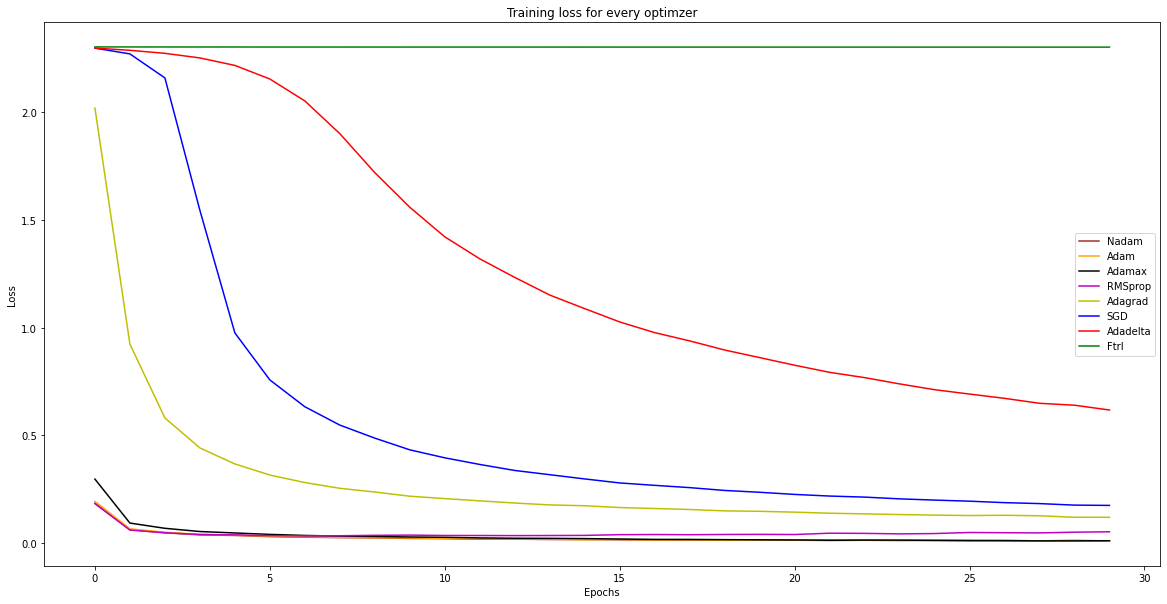

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history_results['Nadam'].history['loss'], color='brown', label="Nadam")
plt.plot(history_results['Adam'].history['loss'], color='orange', label="Adam")
plt.plot(history_results['Adamax'].history['loss'], color='black', label="Adamax")
plt.plot(history_results['RMSprop'].history['loss'], color='m', label="RMSprop")
plt.plot(history_results['Adagrad'].history['loss'], color='y', label="Adagrad")
plt.plot(history_results['SGD'].history['loss'], color='b', label="SGD")
plt.plot(history_results['Adadelta'].history['loss'], color='r', label="Adadelta")
plt.plot(history_results['Ftrl'].history['loss'], color='green', label="Ftrl")
plt.title('Training loss for every optimzer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The vertical axis represent the loss value and the horizontal one represent the epochs (iterations). The lower the loss $\rightarrow$ the better the model. As we can see from the plot Nadam, Adam, and Adamax performed the best. 

#### **Performances on test Set**


In [ ]:
# Code for confusion matrix 

def plot_confusion_matrix(model_dir,cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for  '+model_dir)
    plt.show()

At this point , we have a trained the model for each optimizer, now we will load them one by one and we will compare the accuracy.

In [ ]:
def show_results(model,x_test,y_test,model_dir):
 
  # Predict the values from the validation dataset
  Y_pred = model.predict(x_test)

  # Convert predictions classes to one hot vectors 
  # np.argmax() Returns the indices of the maximum values along an axis.
  Y_pred_classes = np.argmax(Y_pred,axis = 1) 

  # Convert validation observations to one hot vectors
  Y_true = np.argmax(y_test,axis = 1) 

  # Compute the confusion matrix
  confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

  # Plot the confusion matrix
  plot_confusion_matrix(model_dir,confusion_mtx, classes = range(10)) 

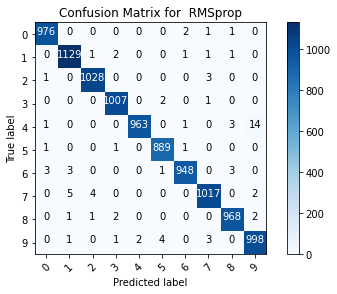

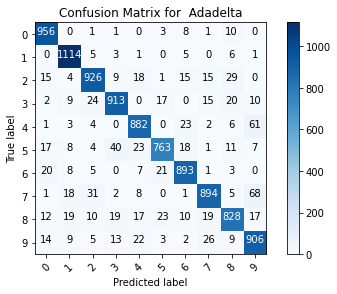

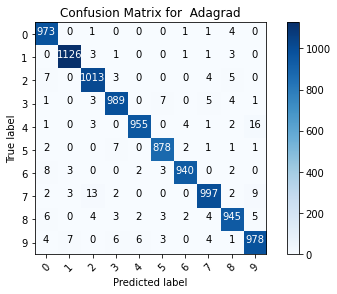

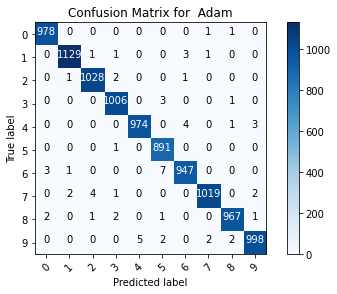

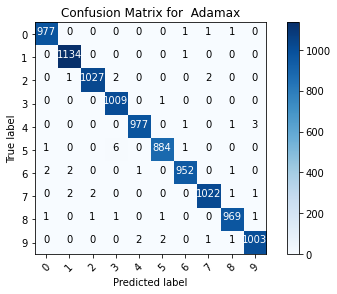

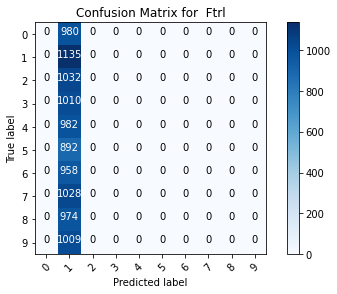

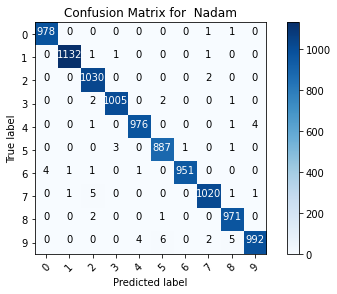

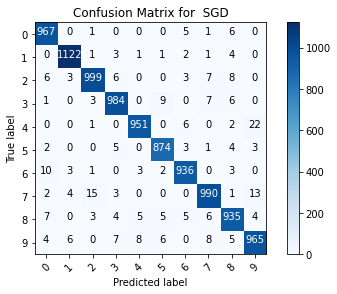

In [ ]:
#Performances on test set

models_dirs = ['RMSprop','Adadelta','Adagrad','Adam','Adamax','Ftrl','Nadam','SGD']
for model_dir in models_dirs:
    model = tf.keras.models.load_model(model_dir)
    show_results(model,x_test,y_test,model_dir)

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.
For example:
Let's take the last matrix (SGD) , the numbers in diagonal are the numbers of samples correctly classified,let's take class 9 for example we have 965 correctly classified,for class 8 we have 935 and so on.<br>

Now we need to compute the precision score. We can do this by computing 

(the number of samples correctly classified)/ (the total number of samples)

In [ ]:
from sklearn.metrics import precision_score, recall_score

for model_dir in models_dirs:
    model = tf.keras.models.load_model(model_dir)
    Y_pred = model.predict(x_test)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(y_test,axis = 1) 
    print('The precision for {} is {} \n'.format(model_dir,precision_score(Y_true, Y_pred_classes,average='micro')))

The precision for RMSprop is 0.9923 

The precision for Adadelta is 0.9075 

The precision for Adagrad is 0.9794 

The precision for Adam is 0.9937 

The precision for Adamax is 0.9954 

The precision for Ftrl is 0.1135 

The precision for Nadam is 0.9942 

The precision for SGD is 0.9723 



From these numbers we can see that Nadam, Adam, Adamax, and RMSprop performed the best. 

After running this code multiple times, I found that Nadam and Adamax perfomed the best everytime. So in conclusion, Nadam and Adamax are the best optimizers for this neural network and Ftrl is the worst. 